In [71]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

current_working_directory = os.getcwd()
print(f"현재 파이썬 코드가 실행되는 디렉토리: {current_working_directory}\n")

file_path_relative = 'olist_orders_dataset.csv'
df = pd.read_csv(file_path_relative, encoding='ISO-8859-1')

display(df.head())

# 데이터 탐색 : 누락, 중복, 이상
df.describe()
df.info()

현재 파이썬 코드가 실행되는 디렉토리: c:\Users\mumu1\Desktop\project_movie_data



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
%pip install pandas-summary

In [ ]:
# from pandas_summary import DataFrameSummary
# # 프로파일링
# dfs = DataFrameSummary(df)
# print(dfs.summary())

In [47]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
# 결측치 삭제
df_clean = df.copy()
df_clean = df_clean.dropna(subset=['order_approved_at',
                             'order_delivered_carrier_date',
                             'order_delivered_customer_date'])

# 이상치 탐지: 계산한 배송시간 차이가 크거나 작은 경우
print('\n=== 이상값 확인 ===')
df_delivered = df[df["order_status"]=="delivered"].copy()

# 데이터 타입 변환
df_delivered["order_approved_at"] = pd.to_datetime(df_delivered["order_approved_at"])
df_delivered["order_purchase_timestamp"] = pd.to_datetime(df_delivered["order_purchase_timestamp"])
df_delivered["order_delivered_carrier_date"] = pd.to_datetime(df_delivered["order_delivered_carrier_date"])
df_delivered["order_delivered_customer_date"] = pd.to_datetime(df_delivered["order_delivered_customer_date"])
df_delivered["order_purchase_timestamp"] = pd.to_datetime(df_delivered["order_purchase_timestamp"])

# 시간 차이 계산 (일 단위)
# 결제까지 걸린 시간: 주문승인일 - 결제일
df_delivered["purchase_to_approved"] = (df_delivered["order_approved_at"] - df_delivered["order_purchase_timestamp"]).dt.total_seconds()/86400
# 주문-배송 걸린 시간: 배송완료일 - 주문승인일
df_delivered["approved_to_carrier"] = (df_delivered["order_delivered_carrier_date"] - df_delivered["order_approved_at"]).dt.total_seconds()/86400
# 택배사-배송 걸린 시간: 배송완료일 - 택배사 전달일
df_delivered["carrier_to_customer"] = (df_delivered["order_delivered_customer_date"] - df_delivered["order_delivered_carrier_date"]).dt.total_seconds()/86400
# 계산-배송 걸린 시간: - 배송완료일 - 주문계산일
df_delivered["purchase_to_customer"] = (df_delivered["order_delivered_customer_date"] - df_delivered["order_purchase_timestamp"]).dt.total_seconds()/86400

# 모든 시간 계산 컬럼에서 음수 값만 찾기
# 시간 계산 컬럼 리스트
time_cols = ["purchase_to_approved","approved_to_carrier","carrier_to_customer","purchase_to_customer"]

# 각 컬럼별 음수 개수 계산
neg_counts = {col: (df_delivered[col] < 0).sum() for col in time_cols}

# 전체 음수 개수 (한 행이라도 음수인 경우)
total_neg = df_delivered[(df_delivered[time_cols] < 0).any(axis=1)].shape[0]

# 결과 출력
print("컬럼별 음수 개수:", neg_counts)
print("전체 음수 개수 (한 행이라도 음수):", total_neg)


=== 이상값 확인 ===
컬럼별 음수 개수: {'purchase_to_approved': np.int64(0), 'approved_to_carrier': np.int64(1350), 'carrier_to_customer': np.int64(23), 'purchase_to_customer': np.int64(0)}
전체 음수 개수 (한 행이라도 음수): 1373


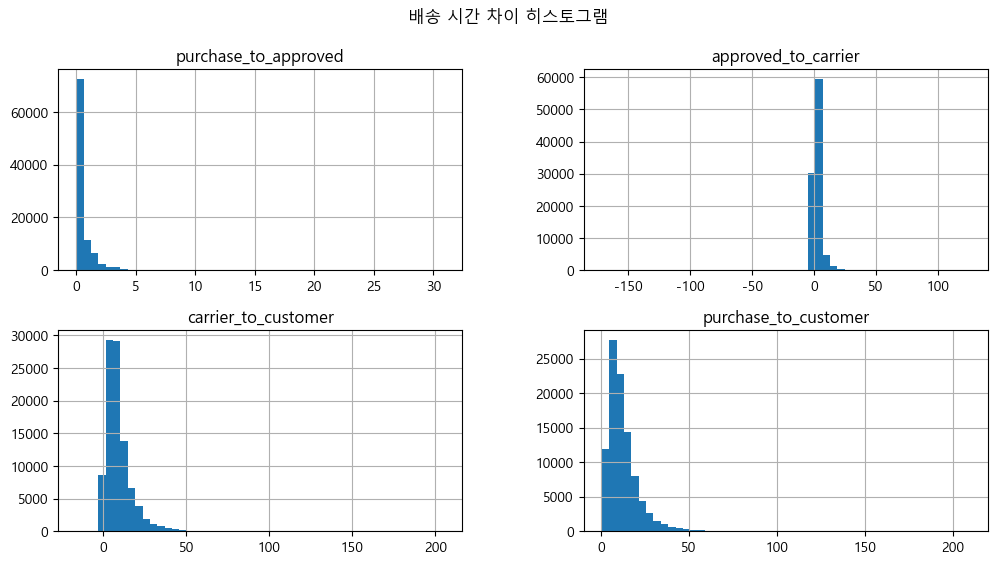

=== Z-score 기준 이상치 비율 (|Z|>3) ===
purchase_to_approved: 2.26%
approved_to_carrier: 1.92%
carrier_to_customer: 1.64%
purchase_to_customer: 1.63%

=== IQR 기준 이상치 비율 ===
purchase_to_approved: 9.27%
approved_to_carrier: 5.80%
carrier_to_customer: 5.25%
purchase_to_customer: 5.08%


In [72]:
# 이상치 탐지 시각화

# 1️⃣ 히스토그램 시각화
df_delivered[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("배송 시간 차이 히스토그램")
plt.show()

# 2️⃣ 극단치 비율 계산
print("=== Z-score 기준 이상치 비율 (|Z|>3) ===")
for col in time_cols:
    z = zscore(df_delivered[col].dropna())
    outlier_ratio = (abs(z) > 3).mean() * 100
    print(f"{col}: {outlier_ratio:.2f}%")

# 3️⃣ IQR 기반 이상치 비율 계산
print("\n=== IQR 기준 이상치 비율 ===")
for col in time_cols:
    data = df_delivered[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    iqr_outlier_ratio = ((data < lower_bound) | (data > upper_bound)).mean() * 100
    print(f"{col}: {iqr_outlier_ratio:.2f}%")

In [75]:
# 이상치 처리: IQR

# IQR 이상치 제거 함수
def remove_iqr_outliers(df, cols):
    df_clean = df.copy()
    
    for col in cols:
        data = df_clean[col].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # IQR 범위를 벗어난 행 제거
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        
        print(f"{col}: 제거 후 데이터 수 = {len(df_clean)}")
    
    return df_clean

# 실행
df_delivered_clean = remove_iqr_outliers(df_delivered, time_cols)

purchase_to_approved: 제거 후 데이터 수 = 87526
approved_to_carrier: 제거 후 데이터 수 = 82605
carrier_to_customer: 제거 후 데이터 수 = 78274
purchase_to_customer: 제거 후 데이터 수 = 77032


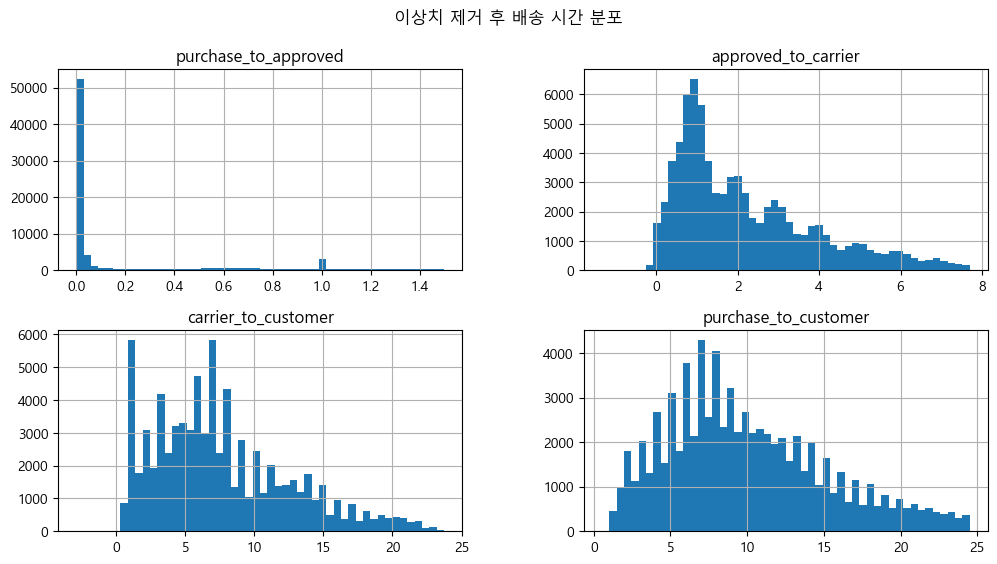

,purchase_to_approved,approved_to_carrier,carrier_to_customer,purchase_to_customer
count,77032.000000,77032.000000,77032.000000,77032.000000
mean,0.212887,2.178443,7.626069,10.017399
std,0.391310,1.718454,4.950664,5.231005
min,0.000000,-1.333345,-2.892384,0.533414
25%,0.008681,0.862248,3.933400,6.116024
50%,0.012627,1.679890,6.879022,9.064572
75%,0.097008,3.115900,10.617341,13.237014
max,1.498310,7.697211,23.727824,24.504051


In [76]:
# 이상치 제거 후 배송 시간 분포 확인

df_delivered_clean[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("이상치 제거 후 배송 시간 분포")
plt.show()

# 기초 통계 확인
df_delivered_clean[time_cols].describe()

In [ ]:
# 분석용 변수 생성
# 